[GD-2]data_augmentation

- 목적 : CutMix 또는 Mixup 비교실험 하기
- 내용 : 기본적인 augmentation 방법을 적용해 모델을 훈련시켜보았다. 이제 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜 보고 결과를 수치화하여 비교하기.

## 1. Augmentation을 적용한 데이터셋 만들기

#### (1) 데이터셋 확인

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


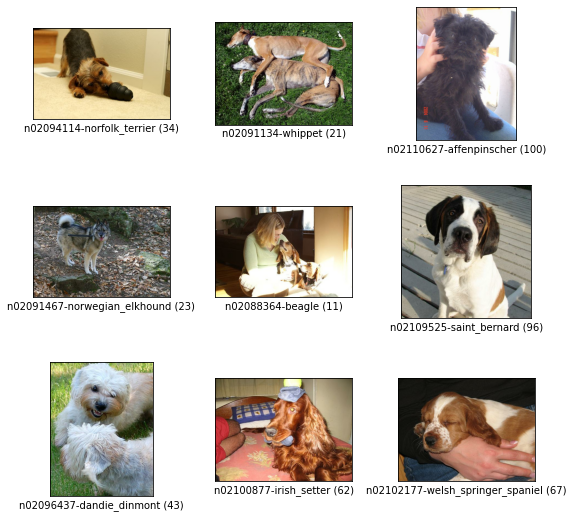

In [5]:
fig = tfds.show_examples(ds_train, ds_info)

#### (2) 기본 Augmentation 기법 함수 (tensorflow)

In [9]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

In [8]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,     
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

#### (3) CutMix

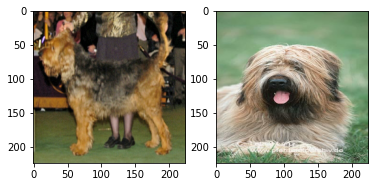

In [11]:
import matplotlib.pyplot as plt

for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [12]:
def get_clip_box(image_a, image_b):

    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(46, shape=(), dtype=int32) tf.Tensor(124, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


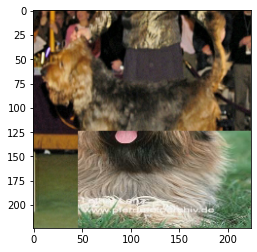

In [13]:
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

In [14]:
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.6452487, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.3547513, 0.       , 0.       ,
   

In [15]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### (4) Mixup

In [16]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.7860738 0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.2139262 0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

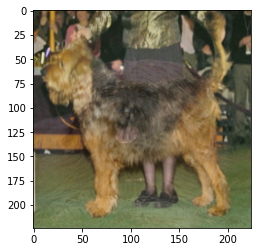

In [17]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [18]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### (5) 학습데이터 : 비교군 만들기

In [19]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [20]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [21]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

## 2. 모델 만들기

In [22]:
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, 
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [23]:
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [24]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [25]:
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

## 3. 모델 훈련하기

In [26]:
EPOCH = 20  

tf.random.set_seed(2021)
resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [27]:
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 211s 227ms/step - loss: 2.1912 - accuracy: 0.4507 - val_loss: 3.1321 - val_accuracy: 0.2476
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 0.7023 - accuracy: 0.8075 - val_loss: 1.1368 - val_accuracy: 0.6701
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 0.2081 - accuracy: 0.9594 - val_loss: 1.0521 - val_accuracy: 0.6954
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0652 - accuracy: 0.9942 - val_loss: 0.8964 - val_accuracy: 0.7399
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0297 - accuracy: 0.9987 - val_loss: 0.9066 - val_accuracy: 0.7397
Epoch 6/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0174 - accuracy: 0.9996 - val_loss: 0.9166 - val_accuracy: 0.7401
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0130 - accuracy: 0.9998 - val_loss: 0.9471 -

In [28]:
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 161s 206ms/step - loss: 2.2522 - accuracy: 0.4353 - val_loss: 2.8982 - val_accuracy: 0.2810
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 0.9166 - accuracy: 0.7383 - val_loss: 1.2446 - val_accuracy: 0.6410
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 0.4536 - accuracy: 0.8746 - val_loss: 1.2480 - val_accuracy: 0.6465
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 0.2366 - accuracy: 0.9462 - val_loss: 1.0615 - val_accuracy: 0.6915
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 0.1375 - accuracy: 0.9729 - val_loss: 1.0257 - val_accuracy: 0.7098
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0693 - accuracy: 0.9898 - val_loss: 0.9707 - val_accuracy: 0.7281
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0413 - accuracy: 0.9954 - val_loss: 0.9858 -

In [29]:
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 163s 208ms/step - loss: 3.8568 - accuracy: 0.2088 - val_loss: 3.2993 - val_accuracy: 0.2079
Epoch 2/20
750/750 [==============================] - 155s 206ms/step - loss: 2.9530 - accuracy: 0.4331 - val_loss: 1.6312 - val_accuracy: 0.5582
Epoch 3/20
750/750 [==============================] - 155s 206ms/step - loss: 2.6713 - accuracy: 0.5171 - val_loss: 1.2589 - val_accuracy: 0.6469
Epoch 4/20
750/750 [==============================] - 155s 206ms/step - loss: 2.4451 - accuracy: 0.5948 - val_loss: 1.2895 - val_accuracy: 0.6536
Epoch 5/20
750/750 [==============================] - 155s 206ms/step - loss: 2.2930 - accuracy: 0.6455 - val_loss: 1.3377 - val_accuracy: 0.6292
Epoch 6/20
750/750 [==============================] - 155s 206ms/step - loss: 2.1811 - accuracy: 0.6786 - val_loss: 1.3452 - val_accuracy: 0.6486
Epoch 7/20
750/750 [==============================] - 155s 206ms/step - loss: 2.0669 - accuracy: 0.7118 - val_loss: 1.1463 -

In [30]:
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 163s 208ms/step - loss: 3.7291 - accuracy: 0.2337 - val_loss: 4.0896 - val_accuracy: 0.1098
Epoch 2/20
750/750 [==============================] - 155s 207ms/step - loss: 2.8392 - accuracy: 0.4849 - val_loss: 1.9197 - val_accuracy: 0.4901
Epoch 3/20
750/750 [==============================] - 155s 206ms/step - loss: 2.5727 - accuracy: 0.5836 - val_loss: 1.4060 - val_accuracy: 0.6116
Epoch 4/20
750/750 [==============================] - 155s 207ms/step - loss: 2.3787 - accuracy: 0.6616 - val_loss: 1.2738 - val_accuracy: 0.6475
Epoch 5/20
750/750 [==============================] - 155s 207ms/step - loss: 2.2522 - accuracy: 0.7101 - val_loss: 1.3487 - val_accuracy: 0.6316
Epoch 6/20
750/750 [==============================] - 155s 206ms/step - loss: 2.1718 - accuracy: 0.7381 - val_loss: 1.1862 - val_accuracy: 0.6734
Epoch 7/20
750/750 [==============================] - 155s 207ms/step - loss: 2.0871 - accuracy: 0.7724 - val_loss: 1.3148 -

## 4. 훈련 과정 시각화하기

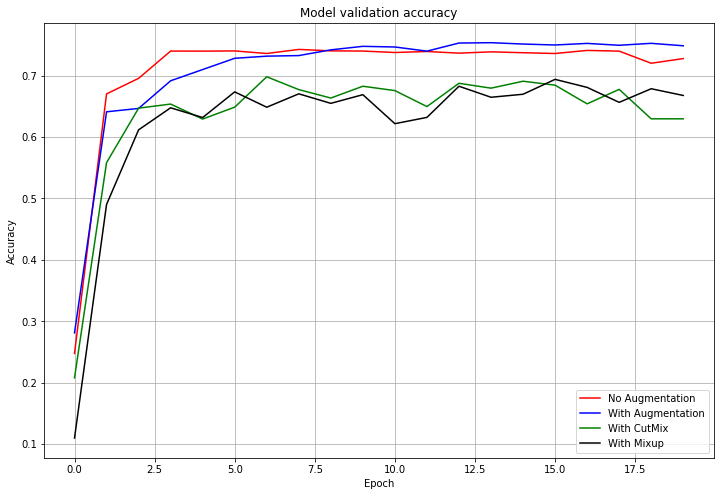

In [31]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='lower right')
plt.grid(True)
plt.show()

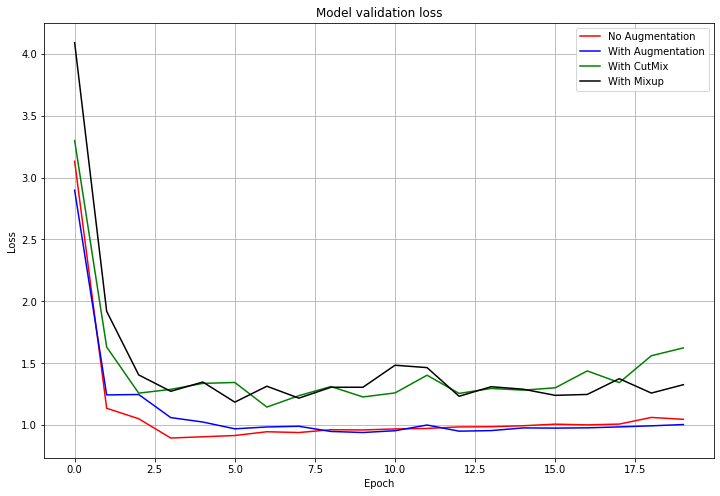

In [32]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='upper right')
plt.grid(True)
plt.show()

## 5. Augmentation에 의한 모델 성능 비교

In [33]:
import pandas as pd

acc_data = {'No Augmentation': history_resnet50_no_aug.history['val_accuracy'], 
            'With Augmentation': history_resnet50_aug.history['val_accuracy'], 
            'With CutMix': history_resnet50_cutmix.history['val_accuracy'], 
            'With Mixup': history_resnet50_mixup.history['val_accuracy']}
acc_df = pd.DataFrame(acc_data)
acc_df

,No Augmentation,With Augmentation,With CutMix,With Mixup
0,0.247551,0.281017,0.207906,0.109841
1,0.670126,0.640975,0.558186,0.490089
2,0.695429,0.646455,0.646922,0.611591
3,0.739855,0.691465,0.653568,0.647505
4,0.739739,0.709771,0.629198,0.631646
5,0.740089,0.728078,0.648554,0.673391
6,0.735891,0.731577,0.697994,0.648438
7,0.742537,0.732509,0.677122,0.670243
8,0.740205,0.741838,0.663363,0.654734
9,0.739855,0.747551,0.682603,0.668843


In [34]:
acc_df.describe()

,No Augmentation,With Augmentation,With CutMix,With Mixup
count,20.000000,20.000000,20.000000,20.000000
mean,0.707218,0.707375,0.636142,0.622680
std,0.109666,0.105784,0.105665,0.128224
min,0.247551,0.281017,0.207906,0.109841
25%,0.733821,0.723502,0.642578,0.631821
50%,0.738048,0.744170,0.658640,0.660506
75%,0.739855,0.750146,0.680241,0.671030
max,0.742537,0.753498,0.697994,0.693797


## 6. 회고

1. augmentation 을 하는 것과 안하는 것은 초기정확도는 거의 비슷하고, ep08 부터 점점 augmentation을 한 모델의 성능이 앞서기 시작하였다.
2. cutmix 와 mixup 을 비교해보자면, 평균값 기준으로 cutmix 의 성능이 약간 앞선다. 
3. 전반적으로 기본 augmentation 모델보다 cutmix나 mixup 모델의 성능이 좋지 못했다.